In [1]:
import sys
sys.path.append("..")
from datetime import date
from pathlib import Path
import pickle
from typing import List

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input, Model
import talib

from btc_predictor.datasets import DataReader
from btc_predictor.utils import print_metrics
from btc_predictor.utils import show_plot

tf.random.set_seed(78)
np.random.seed(78)
mpl.rcParams['figure.figsize'] = [16.0, 9.0]
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = DataReader(data_file="../btc_predictor/datasets/Bitstamp_BTCUSD_d.csv")
df = data.pd

In [3]:
BTCUSD = df.copy()

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)
print(f'Total daily data: {BTCUSD.shape[0]} days')

Total daily data: 1973 days


In [4]:
class Config(object):
    """Config object to store training hyperparameters"""
    def __repr__(self):
        return str(self.__dict__)

config = Config()

In [5]:
config.TRAIN_SIZE = 1680
config.VAL_SIZE = 180
config.WINDOW_SIZE = 16
config.BATCH_SIZE= 128
config.EPOCHS = 10
config.EVALUATION_INTERVAL = 64
config.VALIDATION_STEPS = 64
config.WALK_FORWARD = 30

# 1. Univariate RNN Model

Our best statistical model is ARIMA(5, 1, 1) was trained using 330 days of closing log returns and forcasted on forward 7 days. To make models comparable, we will also try to forecast the forward 7 days log returns. We tried to use 0th order differencing but the model failed to learn. Our ARIMA model provided the hit of using 1st order differencing thus we will apply the same thing.

In [6]:
time_series_data = np.diff(BTCUSD['log_ret'].to_numpy())
train = time_series_data[:config.TRAIN_SIZE]
val = time_series_data[config.TRAIN_SIZE:config.VAL_SIZE+config.TRAIN_SIZE]
test = time_series_data[config.VAL_SIZE+config.TRAIN_SIZE:]

## 1.1 Data Preprocessing using tf.data

In [7]:
def create_data(*,
                data: np.ndarray,
                window_size=31,
                shift_size=1,
                stride_size=1,
                batch_size=15) -> tf.data.Dataset:
    """Generates tf.data dataset using a given numpy array using the tf.data API

    Args:
        data: np.ndarray data in numpy array, to be flattened
        window_size: size of the moving window
        shift_size: step size of the moving window, e.g. [0, 1, 2, 3, 4, 5, 6]
            with shift_size 2 and window_size 3 will be [0, 1, 2], [2, 3, 4], ...
        stride_size: sampling size of the moving window, e.g., [0, 1, 2, 3, 4, 5, 6]
            with stride_size 2 and windows_size 3 will be [0, 2, 4], [1, 3, 5], ...
        batch_size: batch size of the created data

    Returns:
        tf.data.Dataset
    """
    data = tf.data.Dataset.from_tensor_slices(data.reshape(-1, 1))
    data = data.window(size=window_size,
                       shift=shift_size,
                       stride=stride_size,
                       drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size, drop_remainder=True))
    data = data.map(lambda window: (window[:-1], tf.reshape(window[-1:], [])))
    data = data.cache().shuffle(batch_size).batch(batch_size).repeat()

    return data

In [8]:
train_x = create_data(data=train,
                      window_size=config.WINDOW_SIZE,
                      batch_size=config.BATCH_SIZE)
val_x = create_data(data=val,
                    window_size=config.WINDOW_SIZE,
                    batch_size=config.BATCH_SIZE)

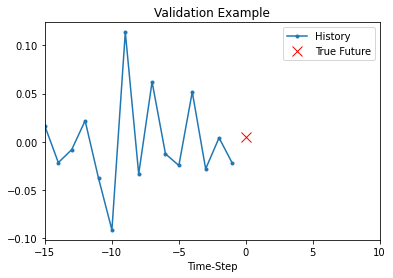

In [9]:
for x, y in val_x.take(1):
    plot = show_plot(plot_data=[x[0].numpy(), y[0].numpy()],
                    title='Validation Example')
    plot.show()

## 1.2 Simple RNN Model

In [10]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=[config.WINDOW_SIZE-1, 1]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [11]:
train_history = simple_lstm_model.fit(train_x, epochs=config.EPOCHS,
                                         steps_per_epoch=config.EVALUATION_INTERVAL,
                                         validation_data=val_x, validation_steps=config.VALIDATION_STEPS)


Epoch 1/10
64/64 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 2/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 3/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 6/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 8/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0012


In [12]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

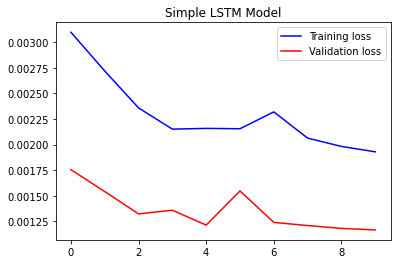

In [13]:
plot_train_history(train_history, "Simple LSTM Model")

## 1.3 Model Evaluation

After training for 10 epochs, validation loss hovers around 0.001, so we cut it short. Now let's look at how the model behaves in walk foward and generate metrics for comparison with our baseline, AR(16), and ARIMA(5, 1, 1) in terms of both RMSE and directional accuracy.

In [14]:
test_x = create_data(data=test,
                     window_size=config.WINDOW_SIZE,
                     batch_size=1)

In [15]:
test_y_true = np.array([])
test_y_pred = np.array([])
for x, y in test_x.take(config.WALK_FORWARD):
    test_y_true = np.append(test_y_true, y[0].numpy())
    test_y_pred = np.append(test_y_pred, simple_lstm_model.predict(x)[0])

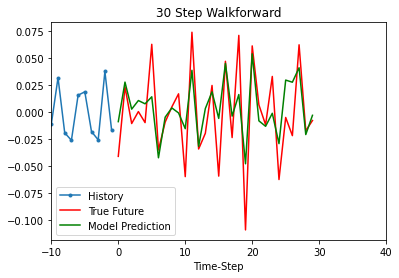

In [16]:
plot = show_plot(plot_data=[test[:10], test_y_true, test_y_pred],
                 delta=config.WALK_FORWARD,
                 title=f'{config.WALK_FORWARD} Step Walkforward',
                 labels=['History', 'True Future', 'Model Prediction'],
                 marker=['.-', 'r-', 'g-'])
plot.show();

In [17]:
print_metrics(y_true=test_y_true, y_pred=test_y_pred)

Prediction RMSE: 0.0287, directional accuracy: 0.7333
